Resumen de Gráficas para Análisis de Accidentes
1. Distribución por Severidad
Tipo: Gráfico de barras verticales
Propósito: Mostrar la frecuencia de accidentes según su nivel de gravedad
Insights esperados:

Identificar los niveles de severidad más comunes

Detectar si hay patrones dominantes (ej. mayoría de accidentes leves vs graves)

Eje X: Niveles de severidad (1-5 típicamente)

Eje Y: Cantidad de accidentes

2. Accidentes por Estado (Top 10)
Tipo: Gráfico de barras horizontales
Propósito: Comparar la frecuencia de accidentes entre estados
Insights esperados:

Identificar los estados con mayor siniestralidad

Detectar patrones geográficos

Barras ordenadas de mayor a menor frecuencia

3. Mapa de Calor: Estado vs Hora
Tipo: Heatmap
Propósito: Visualizar la interacción entre ubicación geográfica y momento del día
Insights esperados:

Horas pico de accidentes por región

Patrones circadianes según ubicación

Combinación crítica de estado+hora con mayor siniestralidad

4. Frecuencia Horaria
Tipo: Gráfico de líneas
Propósito: Analizar la variación de accidentes a lo largo del día
Insights esperados:

Horas valle y pico de accidentalidad

Relación con horarios laborales/noche

Eje X: Horas del día (0-23)

Eje Y: Cantidad de accidentes

5. Distribución por Día de la Semana
Tipo: Gráfico circular
Propósito: Mostrar proporción de accidentes por día
Insights esperados:

Días con mayor ocurrencia (ej. fines de semana vs laborales)

Porcentaje de accidentes por día

Sectores etiquetados con días y porcentajes

6. Visibilidad vs Severidad
Tipo: Gráfico de dispersión con burbujas
Propósito: Analizar relación entre condiciones de visibilidad y gravedad
Insights esperados:

Correlación entre visibilidad y severidad

Tamaño de burbujas representa frecuencia

Identificar umbrales críticos de visibilidad

In [1]:
"""
#🎯 Objetivo:
Identificar patrones temporales y geográficos en los accidentes de tráfico ocurridos en EE.UU. entre 2016 y 2020, y evaluar su gravedad.

"""


'\n#🎯 Objetivo:\nIdentificar patrones temporales y geográficos en los accidentes de tráfico ocurridos en EE.UU. entre 2016 y 2020, y evaluar su gravedad.\n\n'

Importamos el datasset de kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/us-accidents


Se cargan las librerias correspondientes de pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:

# Initialize SparkSession
spark = SparkSession.builder.appName('count_rows').getOrCreate()

1 Explorar cuantos registros y columnas tiene el dataset

In [5]:
df = spark.read.csv(path, header=True, inferSchema=True)

In [6]:
row_count = df.count()

print("Number of rows:", row_count)
df.show()

Number of rows: 7728394
+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation

Contar filas mediante consultas SQL

In [7]:
#Register Dataframe as a SQL temporary view
df.createOrReplaceGlobalTempView('accidents_view')

In [8]:
#count rows sql
row_count = spark.sql('SELECT COUNT(*) FROM global_temp.accidents_view').collect()[0][0]

print("Number of rows:", row_count)

Number of rows: 7728394


2 visualizar las columnas mas relevantes

Start_Time

End_Time

Severity

City

State

Temperature(F)

Weather_Condition

Visibility(mi)

Description

In [9]:
df.select("Start_Time","End_Time","Severity","City","State","Temperature(F)","Weather_Condition","Visibility(mi)","Description").show()

+-------------------+-------------------+--------+------------+-----+--------------+-----------------+--------------+--------------------+
|         Start_Time|           End_Time|Severity|        City|State|Temperature(F)|Weather_Condition|Visibility(mi)|         Description|
+-------------------+-------------------+--------+------------+-----+--------------+-----------------+--------------+--------------------+
|2016-02-08 05:46:00|2016-02-08 11:00:00|       3|      Dayton|   OH|          36.9|       Light Rain|          10.0|Right lane blocke...|
|2016-02-08 06:07:59|2016-02-08 06:37:59|       2|Reynoldsburg|   OH|          37.9|       Light Rain|          10.0|Accident on Brice...|
|2016-02-08 06:49:27|2016-02-08 07:19:27|       2|Williamsburg|   OH|          36.0|         Overcast|          10.0|Accident on OH-32...|
|2016-02-08 07:23:34|2016-02-08 07:53:34|       3|      Dayton|   OH|          35.1|    Mostly Cloudy|           9.0|Accident on I-75 ...|
|2016-02-08 07:39:07|2016-0

3 Limpieza de datos


Elimina nulos si afectan columnas clave.

Convierte Start_Time y End_Time a tipo datetime.

Extrae:

Mes (month)

Día de la semana (weekday)

Hora (hour)

In [10]:
#Eliminamos nulos al data frame
df_limpio = df.dropna()

4. Convertir a tipo datetime

In [11]:
from pyspark.sql.functions import to_timestamp
df_limpio = df_limpio.withColumn("Start_Time", to_timestamp("Start_Time", "yyyy-MM-dd HH:mm:ss"))
df_limpio = df_limpio.withColumn("End_Time", to_timestamp("End_Time", "yyyy-MM-dd HH:mm:ss"))

5 Extraer mes dia de semana y hora

In [12]:
from pyspark.sql.functions import month, dayofweek,hour

#Extraer componentes de fecha/hora

df_final = df_limpio.withColumn("month",month("Start_Time"))
df_final = df_final.withColumn("weekday",dayofweek("Start_Time"))
df_final = df_final.withColumn("hour",hour("Start_Time"))

Análisis Descriptivo y Visualizaciones para Accidentes


A) Distribucion por severidad

In [13]:
from pyspark.sql.functions import count, desc

#analisis
severidad_df = df_final.groupBy("Severity").agg(count("*").alias("total_accidentes")).orderBy(desc("total_accidentes"))

#visualizacion
severidad_df.show()

+--------+----------------+
|Severity|total_accidentes|
+--------+----------------+
|       2|         3348445|
|       4|          112511|
|       3|           68026|
|       1|           25567|
+--------+----------------+



In [14]:
#Porcentaje
total = df_final.count()
severidad_df = severidad_df.withColumn("porcentaje", (severidad_df["total_accidentes"] / total) * 100)
severidad_df.show()

+--------+----------------+------------------+
|Severity|total_accidentes|        porcentaje|
+--------+----------------+------------------+
|       2|         3348445| 94.20168353284762|
|       4|          112511|3.1652679425716173|
|       3|           68026| 1.913773027182914|
|       1|           25567|0.7192754973978415|
+--------+----------------+------------------+



B) Estados con mas accidentes

In [15]:
estados_df = df_final.groupBy("State").agg(count("*").alias("total_accidentes")).orderBy(desc("total_accidentes")).limit(10)
estados_df.show()

+-----+----------------+
|State|total_accidentes|
+-----+----------------+
|   CA|          880453|
|   FL|          529393|
|   TX|          178750|
|   VA|          176331|
|   NY|          168004|
|   PA|          161697|
|   SC|          136485|
|   NC|          132011|
|   OR|          125802|
|   MN|          116608|
+-----+----------------+



C) Horas con más accidentes

In [16]:
hora_df = df_final.groupBy("hour").agg(count("*").alias("total_accidentes")).orderBy(desc("total_accidentes"))
hora_df.show(24)

+----+----------------+
|hour|total_accidentes|
+----+----------------+
|  16|          283840|
|  15|          282309|
|  17|          275184|
|  14|          248908|
|  13|          209890|
|  18|          201421|
|  12|          178535|
|   7|          177060|
|   8|          160293|
|  11|          145683|
|  19|          141648|
|   6|          139373|
|   9|          130760|
|  10|          129469|
|  20|          119149|
|  21|          113098|
|  22|          102340|
|   5|           92358|
|  23|           90536|
|   0|           81850|
|   1|           70312|
|   2|           65432|
|   4|           58659|
|   3|           56442|
+----+----------------+



D) Días con mayor frecuencia

In [17]:
dia_df = df_final.groupBy("weekday").agg(count("*").alias("total_accidentes")).orderBy(desc("total_accidentes"))
dia_df.show()

+-------+----------------+
|weekday|total_accidentes|
+-------+----------------+
|      6|          613030|
|      5|          573657|
|      4|          558927|
|      3|          540262|
|      2|          501906|
|      7|          423522|
|      1|          343245|
+-------+----------------+



E) Efecto de Visibilidad/Clima

In [22]:
from pyspark.sql.functions import count, desc, avg

# Por visibilidad
visibilidad_df = df_final.groupBy("Visibility(mi)").agg(
    count("*").alias("total_accidentes"),
    avg("Severity").alias("severidad_promedio")
).orderBy("Visibility(mi)")

# Por condiciones climáticas
clima_df = df_final.groupBy("Weather_Condition").agg(
    count("*").alias("total"),
    avg("Severity").alias("severidad_promedio")
).orderBy(desc("total")).limit(10)

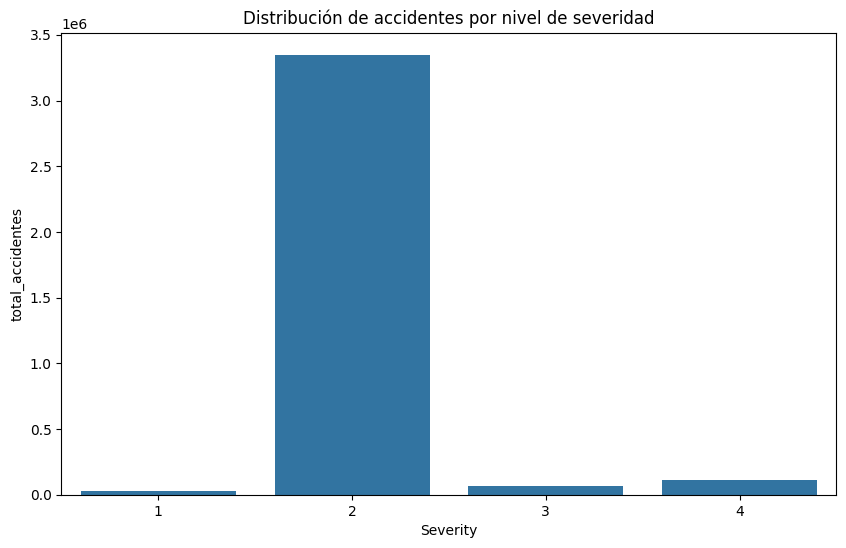

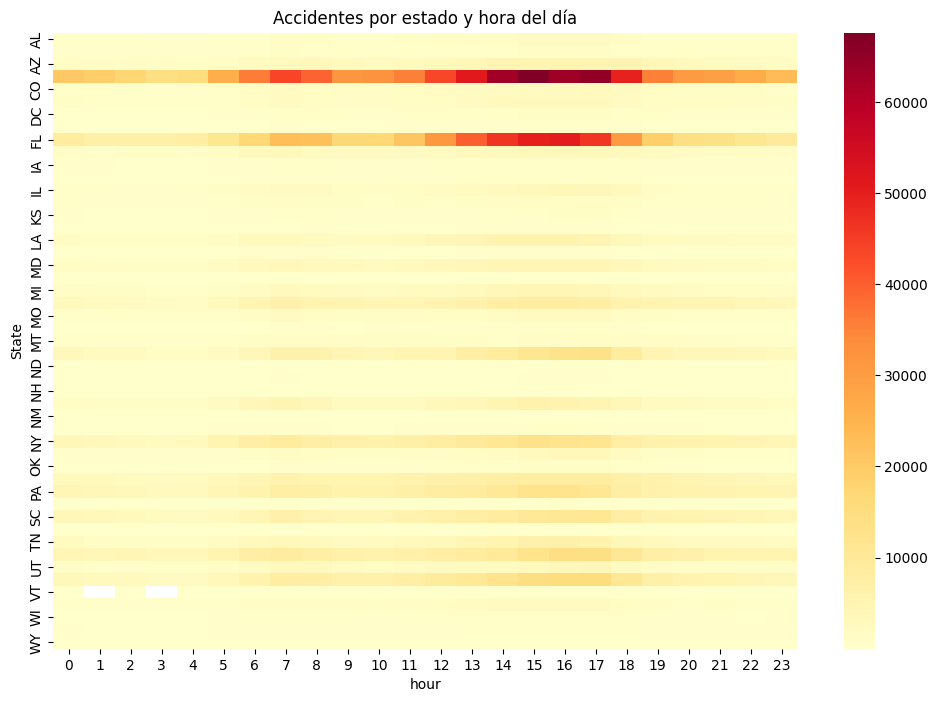

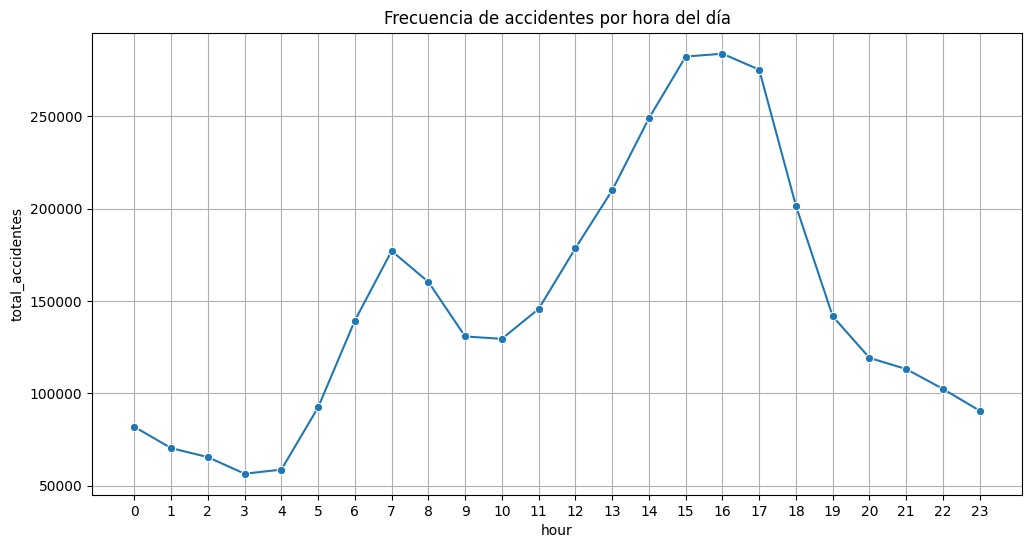

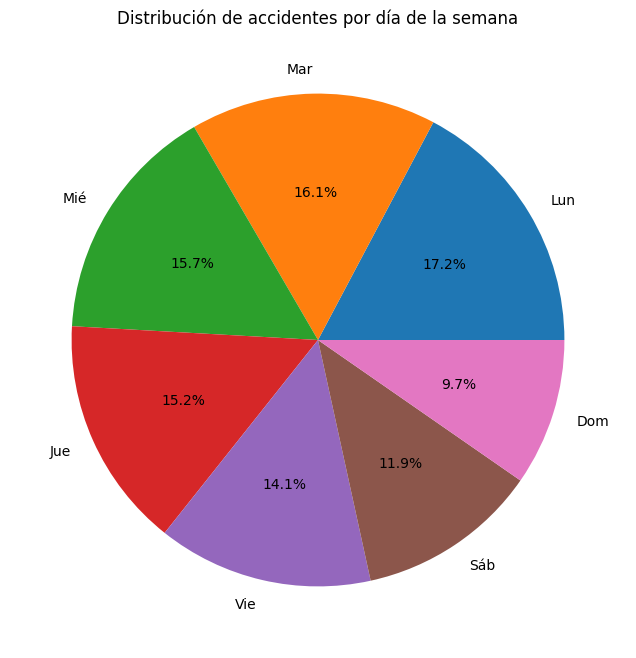

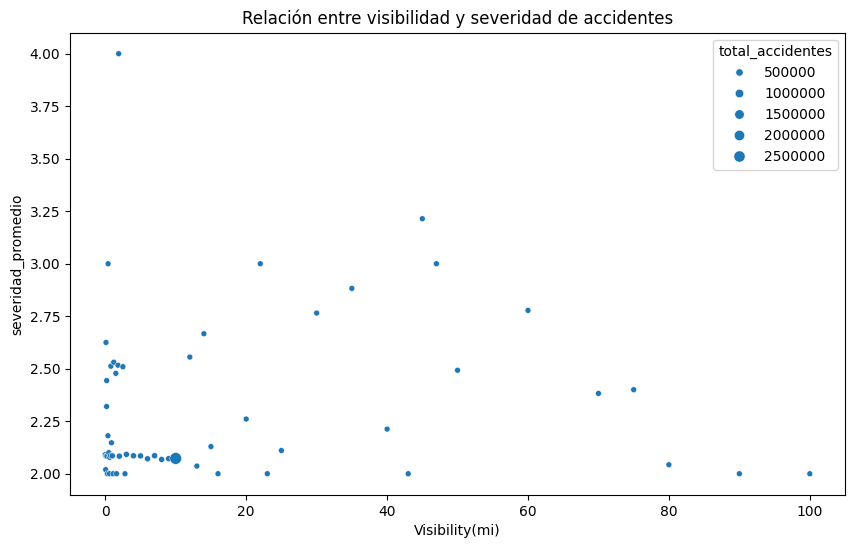

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a Pandas para visualización
severidad_pd = severidad_df.toPandas()
estados_pd = estados_df.toPandas()
hora_pd = hora_df.toPandas()
dia_pd = dia_df.toPandas()
clima_pd = clima_df.toPandas()
visibilidad_pd = visibilidad_df.toPandas()


### a) Gráfico de barras - Distribución por severidad
plt.figure(figsize=(10,6))
sns.barplot(x="Severity", y="total_accidentes", data=severidad_pd)
plt.title("Distribución de accidentes por nivel de severidad")
plt.show()

### b) Mapa de calor - Accidentes por estado y hora
# Prepara los datos
estado_hora = df_final.groupBy("State", "hour").count().toPandas().pivot(index="State", columns="hour", values="count")

plt.figure(figsize=(12,8))
sns.heatmap(estado_hora, cmap="YlOrRd")
plt.title("Accidentes por estado y hora del día")
plt.show()

### c) Gráfico de líneas - Accidentes por hora
plt.figure(figsize=(12,6))
sns.lineplot(x="hour", y="total_accidentes", data=hora_pd, marker="o")
plt.title("Frecuencia de accidentes por hora del día")
plt.xticks(range(0,24))
plt.grid()
plt.show()

### d) Gráfico circular - Días de la semana
plt.figure(figsize=(8,8))
dia_pd['dia_nombre'] = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
plt.pie(dia_pd['total_accidentes'], labels=dia_pd['dia_nombre'], autopct='%1.1f%%')
plt.title("Distribución de accidentes por día de la semana")
plt.show()

### e) Gráfico de dispersión - Visibilidad vs Severidad
plt.figure(figsize=(10,6))
sns.scatterplot(x="Visibility(mi)", y="severidad_promedio", size="total_accidentes", data=visibilidad_pd)
plt.title("Relación entre visibilidad y severidad de accidentes")
plt.show()